In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import parallel_plume_sim as pps
import multiprocessing

##animating
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib.collections
import plotly.graph_objects as go
import plotly.io as py

## training
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [178]:
puff_data_filename = '~/DataAnalysis/data/puff_data/puff_data_20230717_162315.pickle'

# how many seconds to include per chunk?
max_time = 2

# maximum distance in x and y to consider puffs before ignoring them?
min_x = -5
max_x = 20
min_y = -5
max_y = 20

pps.read_puff_data.split_puff_data_into_smaller_dataframes_and_cull_old_puffs(puff_data_filename, 
                                                                              max_time, 
                                                                              min_x, max_x, 
                                                                              min_y, max_y)

Directory /home/flybot/DataAnalysis/data/puff_data/puff_data_20230717_162315 exists, contains 51 files.
Press enter to DELETE all of these files... (hit ctrl-c to exit)
Removed all files in:  /home/flybot/DataAnalysis/data/puff_data/puff_data_20230717_162315


In [133]:
time_scope = np.arange(0.01, 100).round(2)

In [3]:
# This should match your directory name from above -- you need to change this
dirname = '/home/flybot/DataAnalysis/data/puff_data/test/puff_data_20230717_164311'
# Class for reading puff data
puff_reader = pps.read_puff_data.PuffReader(dirname)

In [4]:
# dir='~/DataAnalysis/data/puff_data/'

In [5]:
# dir_odor='~/DataAnalysis/data/Sprints/HighRes/'

In [6]:
# t=pd.read_hdf(dir_odor+'NotWindy/NotWindyMASigned.h5')
# t=pd.read_hdf(dir_odor+'Windy/WindyMASigned.h5')

In [7]:
# steps = np.random.uniform(low=0, high=10, size=(n_points, 2))
# np.cumsum(steps, axis=0)

### Create a Trajectory

In [2]:
# n_points = 200 * 60  # 200Hz for 1 minute, change as needed
# step_size = 0.05  # meters

# steps = np.random.uniform(low=-step_size, high=step_size, size=(n_points, 2))
# points = np.cumsum(steps, axis=0)

# # Ensure the last point is (0,0) by shifting all points by the last point
# points -= points[-1]

# points[:, 0] = ((points[:, 0] - np.min(points[:, 0])) / (np.max(points[:, 0]) - np.min(points[:, 0])) * 20) - 5
# points[:, 1] = ((points[:, 1] - np.min(points[:, 1])) / (np.max(points[:, 1]) - np.min(points[:, 1])) * 20) - 5

# x = points[:,0]
# y = points[:,1]
# time = np.linspace(1,149,len(x))
# time = np.round(time, decimals=2)
# x[-1]=0
# y[-1]=0

In [29]:
n_points = 200 * 60  # 200Hz for 1 minute, change as needed
step_size = 0.05  # meters

steps = np.random.uniform(low=-step_size, high=step_size, size=(n_points, 2))
points = np.cumsum(steps, axis=0)

# Ensure the last point is (0,0) by shifting all points by the last point
points -= points[-1]

# Scale and shift the points to the desired range
points[:, 0] = ((points[:, 0] - np.min(points[:, 0])) / (np.max(points[:, 0]) - np.min(points[:, 0])) * 5) + 5
points[:, 1] = ((points[:, 1] - np.min(points[:, 1])) / (np.max(points[:, 1]) - np.min(points[:, 1])) * 13) + 2

x = points[:,0]
y = points[:,1]
time = np.linspace(1,149,len(x))
time = np.round(time, decimals=2)


In [36]:
step_size = 50

fig = go.Figure(
    data=[go.Scatter(x=x[:1], y=y[:1], mode='lines')],
    layout=go.Layout(
        xaxis=dict(range=[-5,20], autorange=False),
        yaxis=dict(range=[-5,20], autorange=False),
        title="Animation of evolving points",
        shapes=[
            go.layout.Shape(
                type="circle",
                xref="x", yref="y",
                x0=-0.5, y0=-0.5, x1=0.5, y1=0.5,
                line_color="Red",
                fillcolor="Red"
            )
        ],
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 100, "redraw": False}}])])],
        transition = {"duration": 100}
    ),
    frames=[go.Frame(
        data=[go.Scatter(
            x=x[:k+1:step_size],
            y=y[:k+1:step_size],
            mode='lines')]
    )
    for k in range(1, len(x), step_size)]
)

# # Ensure that the aspect ratio is 1:1
# fig.update_yaxes(
#     scaleanchor = "x",
#     scaleratio = 1,
# )
# fig.update_xaxes(
#     scaleanchor = "y",
#     scaleratio = 1,
# )

fig.show()




In [35]:

# py.write_html(fig, 'animation.html')

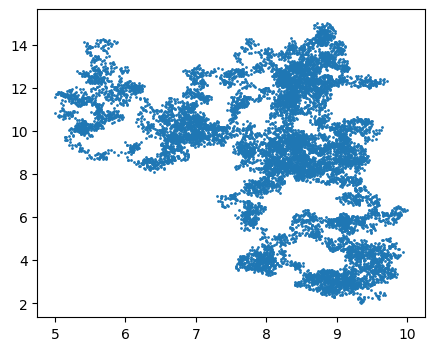

In [34]:
# Create a 10x10 grid
f, ax = plt.subplots(figsize=(5,4))
ax.grid(False)
ax.scatter(x,y, s=1)
f.savefig('traject.jpg')

In [5]:
# c = []
# wx = []
# wy = []
# df_new = pd.DataFrame()

# def process_position(position):
#     time, x, y = position
#     concentration, wind_x, wind_y = puff_reader.get_odor_concentration_at_t_and_position(time, x, y)
#     return concentration, wind_x, wind_y

# with multiprocessing.Pool() as pool:
#     results = pool.map(process_position, [(time[i], x[i], y[i]) for i in range(len(x))])

# c = [result[0] for result in results]
# wx = [result[1] for result in results]
# wy = [result[2] for result in results]

# df_new['odor'] = c
# df_new['windx']=wx
# df_new['windy']=wy
# df_new['x']=x
# df_new['y']=y


In [75]:

n_points = 200 * 60  # 200Hz for 1 minute, change as needed
step_size = 0.05  # meters

def process_position(position):
    time, x, y = position
    concentration, wind_x, wind_y = puff_reader.get_odor_concentration_at_t_and_position(time, x, y)
    return concentration, wind_x, wind_y

def process_and_save_data(index):
    steps = np.random.uniform(low=-step_size, high=step_size, size=(n_points, 2))
    points = np.cumsum(steps, axis=0)

    # Ensure the last point is (0,0) by shifting all points by the last point
    points -= points[-1]

    # Scale and shift the points to the desired range
    points[:, 0] = ((points[:, 0] - np.min(points[:, 0])) / (np.max(points[:, 0]) - np.min(points[:, 0])) * 5) + 5
    points[:, 1] = ((points[:, 1] - np.min(points[:, 1])) / (np.max(points[:, 1]) - np.min(points[:, 1])) * 13) + 2

    x = points[:,0]
    y = points[:,1]
    time = np.linspace(1,149,len(x))
    time = np.round(time, decimals=2)

    with multiprocessing.Pool() as pool:
        results = pool.map(process_position, [(time[i], x[i], y[i]) for i in range(len(x))])

    c = [result[0] for result in results]
    wx = [result[1] for result in results]
    wy = [result[2] for result in results]

    df_new = pd.DataFrame()
    df_new['odor'] = c
    df_new['windx'] = wx
    df_new['windy'] = wy
    df_new['x'] = x
    df_new['y'] = y

    filename = '~/DataAnalysis/data/generated_data_plume_sim/diag{}.h5'.format(index)
    df_new.to_hdf(filename, key='data', mode='w')

# repeat the process for 10 times and save the files as diag1.h5 through diag10.h5
for i in range(1, 11):
    process_and_save_data(i)


Text(0, 0.5, 'odor,v')

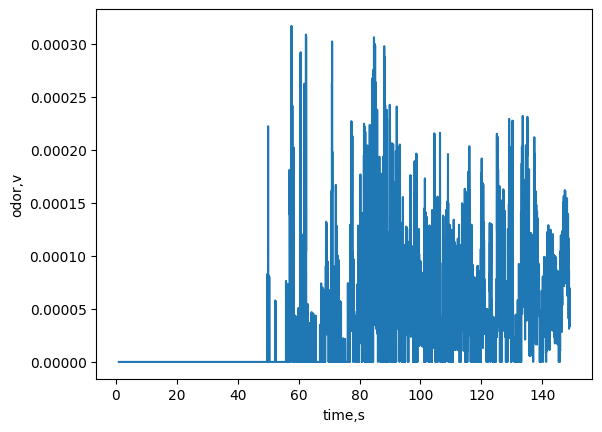

In [73]:
plt.plot(time, df_new.odor)

plt.xlabel('time,s')
plt.ylabel('odor,v')


In [74]:
df_new.to_hdf('~/DataAnalysis/data/generated_data_plume_sim/diag3.h5', key='data', mode='w')

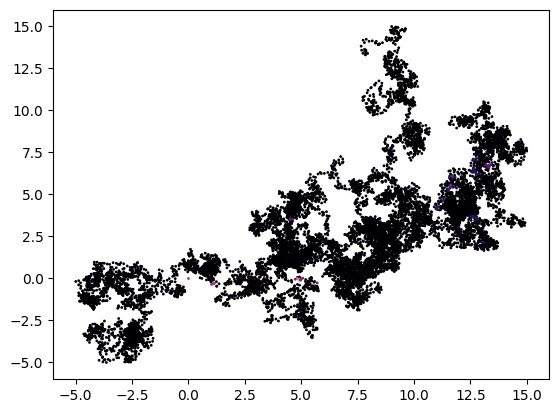

In [23]:
plt.scatter(df_new.x,df_new.y,c=df_new.odor, cmap='magma', vmin=0,vmax=2,s=1)

In [139]:
# c=[]
# wx=[]
# wy=[]
# df_new=pd.DataFrame()

# for i in range(len(x)):
#     concentration, wind_x, wind_y=puff_reader.get_odor_concentration_at_t_and_position(time[i],x[i],y[i])
#     c.append(concentration)
#     wx.append(wind_x)
#     wy.append(wind_y)

In [78]:
# Specify the directory you're working from
folder_path = '/home/flybot/DataAnalysis/data/generated_data_plume_sim/'

# Get a list of all the .h5 files in the directory
files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]

# Initialize an empty dataframe
all_data = pd.DataFrame()

# Loop through the files and read each one into a dataframe
for file in files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_hdf(file_path)
    all_data = pd.concat([all_data, df])

In [79]:
all_data=all_data.reset_index(drop=True)
df=pd.DataFrame()
df = all_data.copy()

In [107]:
all_data.copy()

,odor,windx,windy,x,y,level_0,index
0,0.000000,4.000000e-01,0.0,2.448199,1.030499,NaN,NaN
1,0.000000,4.000000e-01,0.0,2.628665,1.137911,NaN,NaN
2,0.000000,4.000000e-01,0.0,2.940602,0.985632,NaN,NaN
3,0.000000,4.000000e-01,0.0,2.773958,0.902336,NaN,NaN
4,0.000000,4.000000e-01,0.0,2.651320,0.746141,NaN,NaN
...,...,...,...,...,...,...,...
11995,0.000000,2.449294e-17,0.4,14.066791,14.612897,NaN,NaN
11996,0.000000,2.449294e-17,0.4,14.132659,14.705562,NaN,NaN
11997,0.000000,2.449294e-17,0.4,14.303202,14.771791,NaN,NaN
11998,0.000000,2.449294e-17,0.4,14.130829,14.858997,NaN,NaN


In [99]:
def _scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

In [89]:

data=df.odor
# Calculate the min and max values of the array
min_val = np.min(data)
max_val = np.max(data)


df['scaled_odor']=((data - min_val) / (max_val - min_val)) * 10

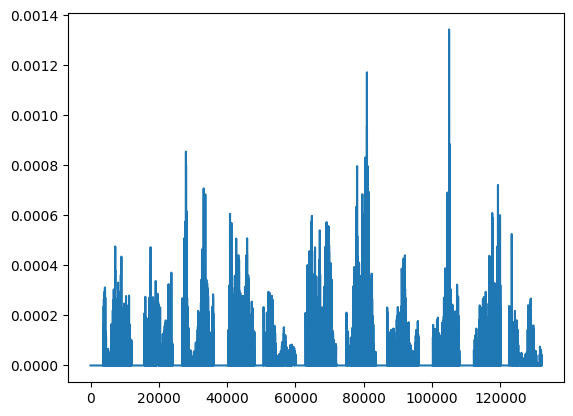

In [90]:
plt.plot(df.odor)

In [92]:
# Preprocess the data
features = ['windx', 'windy', 'x', 'y']  # 'odor' is not included here
target = ['scaled_odor']

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
train_features = torch.Tensor(train_df[features].values)
train_targets = torch.Tensor(train_df[target].values)

test_features = torch.Tensor(test_df[features].values)
test_targets = torch.Tensor(test_df[target].values)

# Reshape to (batch_size, seq_length, n_features)
train_features = train_features.view(-1, 1, 4)  # We now have 4 features
test_features = test_features.view(-1, 1, 4)



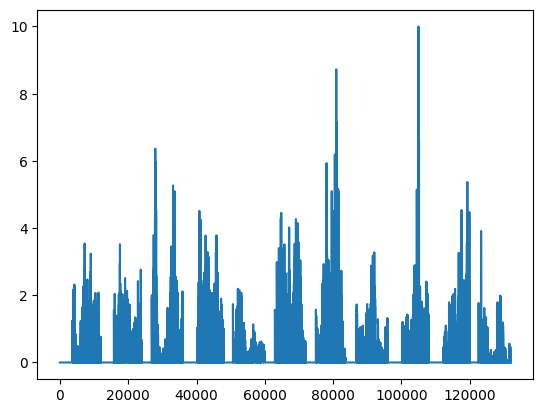

In [91]:
plt.plot(df.scaled_odor)

### RNN Test

In [ ]:

# # Define the RNN model
# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(RNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
#         out, _ = self.rnn(x, h0)  # RNN output and last hidden state
#         out = self.fc(out[:, -1, :])  # Pass RNN output through fully-connected layer
#         return out

# # Initialize the model, loss function and optimizer
# model = RNN(input_size=4, hidden_size=32, output_size=1)  # We now have 4 input features
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # Train the model
# num_epochs = 100
# for epoch in range(num_epochs):
#     model.train()
#     outputs = model(train_features)
#     loss = criterion(outputs, train_targets)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (epoch+1) % 10 == 0:
#         print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# # Test the model
# model.eval()
# with torch.no_grad():
#     predictions = model(test_features)
#     test_loss = criterion(predictions, test_targets)
# print(f'Test Loss: {test_loss.item()}')

### LSTM Test

In [93]:
# Check if a GPU is available and if not, use a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)  # Initial cell state
        out, _ = self.lstm(x, (h0, c0))  # LSTM output and last hidden state
        out = self.fc(out[:, -1, :])  # Pass LSTM output through fully-connected layer
        return out

# Move model to the device
model = LSTM(input_size=4, hidden_size=128, output_size=1, num_layers=3, dropout=0.5).to(device)

# Move tensors to the device
train_features = train_features.to(device)
train_targets = train_targets.to(device)
test_features = test_features.to(device)
test_targets = test_targets.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Lower learning rate

# Train the model
num_epochs = 200  # More epochs
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_features)
    loss = criterion(outputs, train_targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Test the model
model.eval()
with torch.no_grad():
    predictions = model(test_features)
    test_loss = criterion(predictions, test_targets)
print(f'Test Loss: {test_loss.item()}')


cuda
Epoch 10/200, Loss: 0.24455669522285461
Epoch 20/200, Loss: 0.23669934272766113
Epoch 30/200, Loss: 0.23445482552051544
Epoch 40/200, Loss: 0.23406121134757996
Epoch 50/200, Loss: 0.2326246052980423
Epoch 60/200, Loss: 0.2302243560552597
Epoch 70/200, Loss: 0.2255973368883133
Epoch 80/200, Loss: 0.2194005399942398
Epoch 90/200, Loss: 0.21883994340896606
Epoch 100/200, Loss: 0.21742790937423706
Epoch 110/200, Loss: 0.21716223657131195
Epoch 120/200, Loss: 0.21664287149906158
Epoch 130/200, Loss: 0.21628502011299133
Epoch 140/200, Loss: 0.2161291092634201
Epoch 150/200, Loss: 0.21566654741764069
Epoch 160/200, Loss: 0.2154592126607895
Epoch 170/200, Loss: 0.2151976078748703
Epoch 180/200, Loss: 0.2147374004125595
Epoch 190/200, Loss: 0.21455255150794983
Epoch 200/200, Loss: 0.2143820822238922
Test Loss: 0.21658912301063538


### GRU Test

In [90]:
# Define the GRU model
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        out, _ = self.gru(x, h0)  # GRU output and last hidden state
        out = self.fc(out[:, -1, :])  # Pass GRU output through fully-connected layer
        return out

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GRU(input_size=4, hidden_size=256, 
            output_size=1, num_layers=3, dropout=0.5).to(device)  # Increased complexity
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Lower learning rate

# Move the data to the device
train_features = train_features.to(device)
train_targets = train_targets.to(device)
test_features = test_features.to(device)
test_targets = test_targets.to(device)

# Train the model
num_epochs = 200  # More epochs
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_features)
    loss = criterion(outputs, train_targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Test the model
model.eval()
with torch.no_grad():
    predictions = model(test_features)
    test_loss = criterion(predictions, test_targets)
print(f'Test Loss: {test_loss.item()}')


Epoch 20/200, Loss: 0.009137991815805435
Epoch 40/200, Loss: 0.00897623598575592
Epoch 60/200, Loss: 0.008957083337008953
Epoch 80/200, Loss: 0.008953332901000977
Epoch 100/200, Loss: 0.00895328726619482
Epoch 120/200, Loss: 0.008950091898441315
Epoch 140/200, Loss: 0.008950561285018921
Epoch 160/200, Loss: 0.00895211473107338
Epoch 180/200, Loss: 0.00894779060035944
Epoch 200/200, Loss: 0.008944452740252018
Test Loss: 0.009973610751330853


In [94]:
test = pd.read_hdf('/home/flybot/DataAnalysis/data/diag12.h5')

In [95]:
# Assume new_data is a DataFrame with the same structure as your training data
new_df = pd.DataFrame()
new_df['windx']=test.windx
new_df['windy']=test.windy
new_df['x']=test.x
new_df['y']=test.y

In [96]:
# Now, let's predict the 'odor' for the new data
new_features = ['windx', 'windy', 'x', 'y']  # 'odor' is not included here
new_df[new_features] = scaler.transform(new_df[new_features])  # Use the same scaler object as before
new_features_tensor = torch.Tensor(new_df[new_features].values).to(device)  # Move tensor to the same device as the model
new_features_tensor = new_features_tensor.view(-1, 1, 4)  # We now have 4 features

# Generate predictions
model.eval()
with torch.no_grad():
    new_predictions = model(new_features_tensor)


(145.0, 150.0)

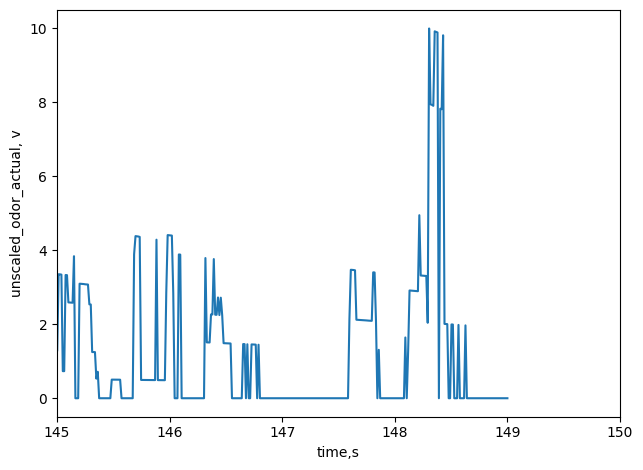

In [138]:
plt.plot(np.linspace(0,149,len(test)), test_odor)
plt.xlabel('time,s')
plt.ylabel('unscaled_odor_actual, v')
plt.tight_layout()
plt.xlim(145,150)

In [123]:
test_odor=_scale_data(test.odor)
scaled_predictions = _scale_data(new_predictions.cpu().numpy())

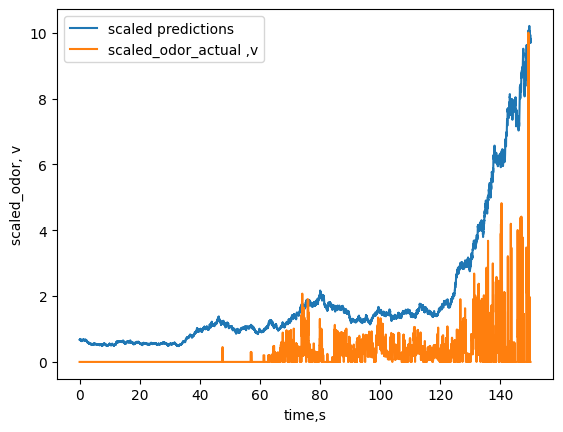

In [129]:
plt.plot(np.linspace(0,150,len(test)),new_predictions.cpu().numpy()*10 , label='scaled predictions')
plt.plot(np.linspace(0,150,len(test)),test_odor, label='scaled_odor_actual ,v')
plt.xlabel('time,s')
plt.ylabel('scaled_odor, v')
plt.legend()
plt.savefig('pred.jpg')

In [101]:
import seaborn as sns

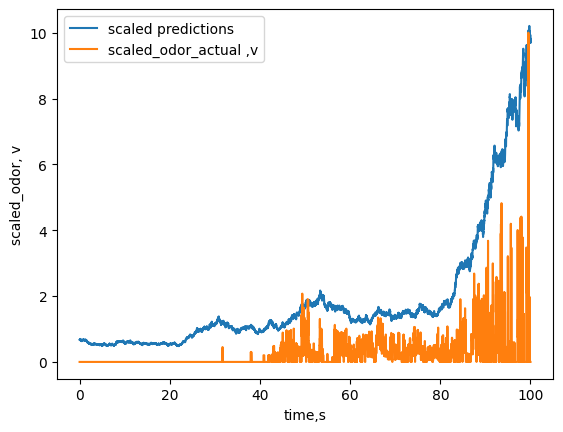

In [125]:
plt.plot(np.linspace(0,100,len(test)),new_predictions.cpu().numpy()*10 , label='scaled predictions')
plt.plot(np.linspace(0,100,len(test)),test_odor, label='scaled_odor_actual ,v')
plt.xlabel('time,s')
plt.ylabel('scaled_odor, v')
plt.legend()

Text(0, 0.5, 'scaled_odor, v')

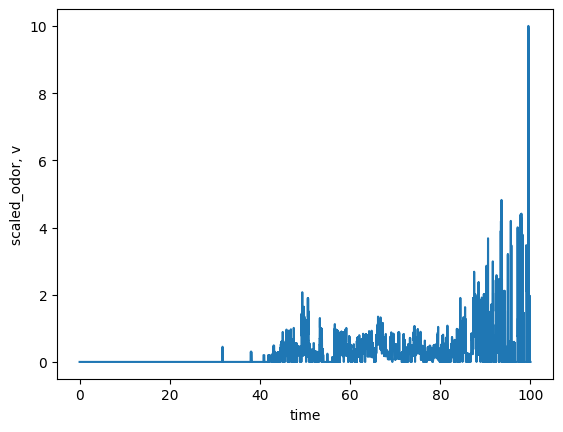

In [117]:
plt.plot(np.linspace(0,100,len(test)),test_odor)
plt.xlabel('time')
plt.ylabel('scaled_odor, v')